# 자연어 처리
자연어 처리(natural language processing, NLP)는 **언어에 대한 계산적 기술을 의미**한다. 

## 21.1 워드 클라우드
단어와 그 개수를 시각화하는 한 가지 방법은 단어의 크기를 단어의 개수에 비례하도록 보여주는 워드 클라우드이다.

일반적으로 데이터 과학자들은 워드 클라우드를 선호하지 않는데, '이 곳에 단어를 끼워 넣을 공간이 있네' 정도 말고는 단어의 위치가 어떠한 의미도 가지지 않기 때문이다.

어쩌다가 워드 클라우드를 만들 상황이 온다면 각 축에 어떻게 의미를 부여할 수 있을지 고민해 보자. e.g. 데이터 과학과 연관된 각 유행어에 0-100 사이의 숫자 두 개가 주어졌다고 해보자. 첫 번째 숫자는 채용공고에 등장한 유행어의 빈도를, 두 번째는 이력서에 등장한 빈도를 의미한다.

In [91]:
data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

채용공고에 등장하는 빈도를 가로축으로, 이력서에 등장하는 빈도를 세로축으로 설정한다면, 조금 더 많은 정보를 제공할 수 있다.

In [92]:
import matplotlib.pyplot as plt

def text_size(total: int) -> float:
    """total이 0이면 8, total이 200이면 28을 반환"""
    return 8 + total / 200 * 20

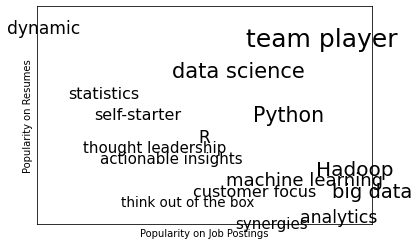

In [93]:
for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word,
            ha='center', va='center',
            size=text_size(job_popularity + resume_popularity))

plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
plt.xticks([])
plt.yticks([])
plt.show()

만약 위의 그림이 단순히 plot, x, y 축 위에 표현되지 않고 그저 빈도수가 높은 순으로 글자의 크기만 크게 그림으로 표현된다면 딱히 어떤 정보를 제공하지 않는다.

## 21.2 n-그램 언어모델
누군가 데이터 과학에 관한 수천 개의 웹페이지를 만들어 검색 엔진의 순위를 높이고 싶어한다. 프로그래밍으로 웹사이트를 대량으로 만들어 낼 방법이 없는지 궁금해하고 있다. 어떻게든 언어 모델을 만들 방법을 찾아야 한다.

한 가지 방법은 문서가 여러 개 있는 말뭉치(corpus, 코퍼스)를 구해서 언어에 대한 통계적 모델을 만드는 것이다. 여기서는 마이크 루키디스(Mike Loukides)의 에세이 What Is Data Science?를 사용해 보자.

9장 '파이썬으로 데이터 수집하기'에서와 같이 requests와 BeautifulSoup 라이브러리를 사용해서 데이터를 수집하자. 이때 신경 쓰면 좋을 몇가지 이슈가 있다.

첫째, 텍스트 안의 따옴표가 유니코드 문자 u\"u2019"이다. 이를 일반 아스키 따옴표로 바꾸는 함수를 만들자.

In [94]:
def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

마침표를 기준으로 웹페이지 안의 텍스트에서 문장들을 봅아보자(마침표는 문장이 어디서 끝나는지를 알게 해주는 신호다.) 이것은 re.findall을 이용하면 간단하게 구현할 수 있다.

In [95]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

content = soup.find("div", "article-body")  # article-body div를 찾아라.
regex = r"[\w']+|[\.]"  # 단어 또는 마침표를 찾아라.

document = []

for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

TypeError: 'NoneType' object is not callable

텍스트를 단어의 열로 만들었으니, 이제 다음과 같은 방법으로 언어를 모델링 할 수 있다. 먼저, 시작 단어를 하나 준다. 여기서는 이 단어를 'book'이라고 해보자. 그리고 문서들을 주욱 훑으면서 'book'이라는 단어 다음에 등장하는 단어들이 무엇인지 확인한다. 이 중 하나를 임의로 선택해서 다음 단어가 되게 하고, 문장 끝을 나타내는 마침표가 등장할 때까지 이 과정을 계속 반복한다. 주어진 문서의 바이그램(bigram, 2-gram) 빈도를 사용하기 때문에, 우리는 이러한 방식을 바이그램 모델(bigram model)이라고 부른다.

시작 단어는 어떻게 고를까? 마침표 다음에 등장하는 단어들 중에서 임의로 하나를 선택하는 방법이 있다. 각 단어 뒤에 어떤 단어가 따라오는지 계산해보자. zip은 입력된 리스트 중 하나라도 처리가 끝나면 종료되기 때문에, zip(document, document[1:]을 사용하면 document에서 연속해서 나온 단어들을 딱 맞게 보여줄 것이다.

In [ ]:
from collections import defaultdict

transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
    transitions[prev].append(current)

이제 문장을 생성할 준비가 되었다.

In [ ]:
def generate_using_bigrams() -> str:
    current = "."  # 마침표의 다음 단어가 문장을 새로 시작할 것이다.
    result = []
    while True:
        next_word_candidates = transitions[current]  # (current, _) 바이그램
        current = random.choice(next_word_candidates)  # 하나를 랜덤으로 골라라.
        result.append(current)  # results에 추가하라.
        if current == ".": return " ".join(result)  # "."가 나오면 종료해라.

이렇게 생성된 문장은 전혀 말이 되지 않지만, 웹사이트에서 데이터 과학의 느낌은 풍기기는 할 것이다. 

세 개의 연속된 단어를 보는 **트라이그램(trigram)** 을 사용하면 문장을 조금 더 그럴듯하게 만들 수 있다.(일반적으로는, n개의 연속된 단어를 고려하는 n-그램을 보겠지만, 여기서는 3개만 봐도 충분할 것이다.) 이제 다음 단어는 직전 두 개의 단어에 따라 바뀐다.

In [ ]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in zip(document, document[1:], document[2:]):
    if prev == ".":  # 직전 단어가 마침표하면
        starts.append(current)  # current는 시작 단어가 될 수 있다.
        
    trigram_transitions[(prev, current)].append(next)

이번에는 시작 단어를 따로 관리해야 한다. 문장 생성 자체는 비슷한 방식으로 할 수 있다.

In [ ]:
def generate_using_trigram() -> str:
    current = random.choice(starts)  # 임의의 시작 단어를 정한 후
    prev = "."  # 마침표를 앞에 덧붙인다.
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)
        
        prev, current = current, next_word
        result.append(current)
        
        if current == ".":
            return " ".join(result)

트라이그램을 사용하면 좀 더 그럴듯한 문자들이 생성된다.

트라이그램에서 더 그럴듯한 문장들이 생성되는 이유는 다음 단어를 생성하는 각 단계에서 선택할 수 있는 단어의 수가 바이그램을 사용할 때보다 훨씬 적어지고, 많은 경우 딱 하나의 단어만 선택할 수밖에 없기 때문이다. 원문에 있었던 문장(또는 긴 문구)을 그대로 생성할 가능성도 높다. 데이터 과학 관련 에세이 여러 개 모아서 더 많은 데이터로 n-그램을 계산하면 성능이 더욱 좋아질 것이다.

## 21.3 문법 규칙
문뻐에 맞는 문장을 생성할 수 있도록 **문법 규칙**을 사용해서 언어를 모델링할 수도 있다.

In [ ]:
from typing import List, Dict

# 문법 규칙을 나타내는 타입 별칭
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

여기서 항목 앞에 밑줄이 있으면 더 확장할 수 있는 규칙(rule), 나머지를 **종결어(terminal)** 라고 하자.

e.g. "_S"는 문장 규칙을 의미하며 "_NP"라는 명사구 규칙과 "_VP"라는 동사구 규칙을 생성한다.

동사규 규칙은 "_V"라는 동사 규칙을 생성하거나, 동사와 명사구로 이어지는 규칙을 생성할 수 있다.

"_NP" 규칙의 경우 자기 자신을 다시 생성할 수 있다는 것에 주목해보자.


문법 규칙은 재귀적(recursive)일 수 있기 때문에, 이와 같은 유한 문법(infinite grammars)이라도 무한히 많은 문장을 생성할 수 있다. 이 문법 규칙으로부터 문장을 어떻게 생성할까? 일단 문장 규칙 ["_S"]로부터 시작한다고 했을 때, 이를 대체할 수 있는 항목 중에서 임의로 한 가지를 선택하고, 모든 항목이 종결어일 때까지 이 과정을 반복한다.

예를 들어 아래와 같은 과정으로 문장이 생성될 수 있다.

['_S']

['_NP', '_VP']

['_N', '_VP']

['Python', '_VP']

['Python', '_V', '_NP']

['Python', 'trains', '_NP']

['Python', 'trains', '_A', '_NP', '_P', '_A', '_N']

['Python', 'trains', 'logistic', '_NP', '_P', '_A', '_N']

['Python', 'trains', 'logistic', '_N', '_P', '_A', '_N']

['Python', 'trains', 'logistic', 'data science', '_P', '_A', '_N']

['Python', 'trains', 'logistic', 'data science', 'about', '_A', '_N']

['Python', 'trains', 'logistic', 'data science', 'about', 'logistic', '_N']

['Python', 'trains', 'logistic', 'data science', 'about', 'logistic', 'Python']

이것을 실제 코드로 구현하기 위해 종결어를 인식할 수 있는 함수를 만들어 보자.

In [96]:
def is_terminal(token: str) -> bool:
    return token[0] != "_"

다음으로 토큰 목록이 주어졌을 때 이를 문장으로 변환하는 함수를 만들자. 이 함수에서는 가장 먼저 등장하는 규칙 항목이 무엇인지를 찾는다. 규칙 항목을 찾을 수 없다면 모든 항목이 종결어로 구성되어 있다는 것을 의미하므로 함수를 종료하면 되고, 규칙 항목을 찾는다면 그것을 대체할 수 있는 여러 항목 중 하나를 임의로 선택한다. 이때 선택된 항목이 종결어, 즉 단어라면 기존 항목을 단순히 대체하기만 하면 된다. 하편 선택된 항목이 종결어가 아니라면, 공백으로 구분된 비종료 토큰들을 split한 후 현재 토큰의 목록에 삽입해야 한다. 어떤 경우든, 새로 얻게 된 코큰의 목록에 대해 동일한 과정을 반복한다.

위 과정을 종합하면 아래와 같다.

In [97]:
def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    for i, token in enumerate(tokens):
        # 종결어인 경우, 넘어가라.
        if is_terminal(token): continue
            
        # 종결어가 아닌 경우
        # 대체할 토큰을 임의로 정하라.
        replacement = random.choice(grammar[token])
        
        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # 대체된 구가 예를 들어 "_NP _VP"라면
            # 공백을 기준으로 나누고 slice해서 넣어라.
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
            
        # 새로운 토큰 목록에 expand를 적용해라.
        return expand(grammar, tokens)
    
    # 여기까지 왔다면 리스트는 종결어만으로 구성되어 있고 프로세스는 종료된다.
    return tokens

이제 문장을 생성해 보자.

In [98]:
def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

사실 문법 규칙은 역으로 이용하는 게 더 흥미롭다. 즉, 주어진 문장을 문법 기준으로 **파싱(parsing)** 해서 명사와 동사 등을 인식한다면 문장을 더 잘 이해할 수 있다.

데이터 과학으로 문서를 생성하는 것도 꽤 멋지지만, 문서를 이해할 수 있는 것은 더욱 근사한 일이다. 

## 21.4 여담: 깁스 샘플링
몇몇 확률분포는 쉽게 표본(sample)을 생성할 수 있다. e.g. 균등분포의 확률변수(uniform random variable)는 다음과 같이 얻을 수 있고

random.random()

정규분포의 확률변수(normal random variables)는 다음과 같이 얻을 수 있다.

inverse_normal_cdf(random.random())

하지만 다른 일반적인 확률분포로부터 테이터를 샘플링하는 것은 간단하지 않다. 이런 경우 **깁스 샘플링(Gibbs sampling)** 은 다차원 분포 안, 몇 개의 조건부 분포(conditional distribution)를 알고 있다는 가정하에 표본을 생성할 수 있게 해준다.

두 개의 주사위를 상상해보자. x가 첫 번째 주사위의 눈이고 y는 주사위 두 개의 눈의 합일 때, (x, y)쌍을 여러 개 생성하려고 한다면 표본을 다음과 같이 직접 생성할 수 있다.

In [99]:
from typing import Tuple
import random

def roll_a_die() -> int:
    return random.choice([1,2,3,4,5,6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

이제 조건부 확률만 안다고 가정해 보자. x가 주어졌을 때 y의 조건부 확률을 구하는 것도 쉽다. x값을 안다면 y가 x+1, x+2, x+3, x+4, x+5 또는 x+6일 확률은 전부 같다.

In [100]:
def random_y_given_x(x: int) -> int:
    """x + 1, x + 2, ... , x + 6일 확률은 전부 동일하다."""
    return x + roll_a_die()

하지만 반대의 경우는 조금 더 복잡하다. e.g. yrㅏ 2라는 것을 안다면 x는 반드시 1이다(두 주사위 눈의 합이 2가 되는 방법은 두 주사위의 눈이 모두 1일 때 뿐이다). y가 3이라면 x는 동일한 확률로 1 또는 2이다. 같은 방법으로 y가 11이라면 x는 5 또는 6이어야 한다.

In [101]:
def random_x_given_y(y: int) -> int:
    if y <= 7:
        # 총합이 7 이하라면 첫 번째 주사위의 눈은 같은 확률로
        # (총합 - 6), (총합 - 5), ..., 6이다.
        return random.randrange(y - 6, 7)

깁스 샘플링은 일단 (유효한) x, y 값으로 시작해서, y에 대한 조건부 확률로 x를 생성하고, x에 대한 조건부 확률로 y를 생성하는 방식으로 동작한다. 이렇게 여러 번 반복하면 x, y는 결합확률분포를 따르는 표본이 된다.

In [102]:
def gibbs_sample(num_iters: int  = 100) -> Tuple[int, int]:
    x, y = 1, 2  # 초깃값은 별로 상관없다.
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    
    return x, y

이 값들을 원래 분포에서 직접 샘플링한 것과 비교해 보면 유사한 결과가 나오는 것을 확인할 수 있다.

In [103]:
def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

## 21.5 토픽 모델링
사용자들의 관심사를 이해할 수 있는 더 정교한 방법은 관심사의 기반이 되는 주제, 또는 토픽(topic)을 파악하는 것이다. **LDA(Latent Dirichlet Allocation)** 라고 불리는 방법은 문서들의 꾸러미인 말뭉치에서 공통된 토픽을 뽑아내는 데 사용된다. 여기서는 '사용자들의 관심사' 말뭉치에 LDA를 적용해 보자.

LDA는 말뭉치에 대한 확률모델을 만든다는 점에서 13장. 나이브 베이즈에서 살펴본 나이브 베이즈 분류기와 공통점이 있다. 모델은 아래의 가정들을 가진다.

- 토픽의 수는 K개로 고정되어 있다.
- 각 토픽과 단어의 확률분포를 연관 짓는 확률변수가 있다. 특정 토픽 k가 주어졌을 때 단어 w를 볼 확률이라고 생각하면 된다.
- 각 문서와 토픽의 확률분포를 연관 짓는 확률변수도 있다. 특정 토픽 d가 주어졌을 때 토픽 k를 볼 확률이라고 생각하면 된다.
- 문서 안의 각 단어는 문서의 토픽 분포로부터 먼저 임의의 토픽이 선택된 뒤, 토픽의 단어 분포로부터 생성되었다고 가정한다.

먼저, 문서의 집합 documents가 있고, 각 문서는 단어의 목록으로 구성되어 있다고 하자. 그리고 document_topics는 각 문서의 각 단어에 0부터 K-1 사이의 숫자로 된 토픽들을 할당한다.

이에 따르면 4번째 문서의 5번째 단어는 다음고 같으며

documents[3][4]

그 단어를 생성한 토픽은 다음과 같다.

document_topics[3][4]

이는 각 문서의 토픽 분포를 명시적으로 나타냄과 동시에, 각 토픽의 단어 분포를 암시적으로 나타내 준다.

토픽 1이 특정 단어를 생성하는 횟수와 임의의 단어를 생성하는 횟수를 비교하면, 토픽 1이 특정 단어를 생성할 가능도를 계산할 수 있다. (13장. 나이브 베이즈 에서 스팸 필터를 만들 때도 각 단어가 스팸 메일에 등장하는 횟수와 스팸 메일에 등장하는 전체 단어의 수를 비교했다.)

여기서 토픽을 단순히 숫자로 표기했지만, 각 토픽에서 큰 영향을 끼치는 단어들을 보고 각 토픽에 의미 있는 이름을 부여할 수도 있다. 이제 어떻게든 document_topics를 생성하기만 하면 되는데, 이런 경우 깁스 샘플링이 유용하게 쓰인다.

먼저 모든 문서의 모든 단어에 임의의 토픽을 부여하는 것으로 시작한다. 그리고 각 문서의 단어를 하나씩 살펴보면, 현재의 문서-토픽 분포와 토픽-단어 분포에 따라 각 토픽에 가중치를 할당한다. 그 다음 그 가줓이를 사용해서 해당 단어에 알맞은 새로운 토픽을 할당한다. 이 과정을 여러 번 반복하면 문서-토픽 분포와 토픽-단어 분포의 결합확률분포로부터 나오는 표본을 얻게 된다.

이를 구현하기 위해 일단 주어진 가중치의 집합에서 임의의 인덱스를 뽑는 함수가 필요하다.

In [104]:
def sample_from(weights: List[float]) -> int:
    """i를 weights[i] / sum(weights)의 확률로 반환"""
    total = sum(weights)
    rnd = total * random.random()  # 0과 total 사이에서 균일하게 선택
    for i, w in enumerate(weights):
        rnd -= w  # 아래의 식을 만족하는 가장 작은 i를 반환
        if rnd <= 0: return i  # weights[0] + ... + weights[i] >= rnd

e.g. 가중치가 [1,1,3]이라면 1/5의 확률로 0, 1/5의 확률로 1, 3/5의 확률로 2를 반환하게 된다.

아래의 코드는 테스트 케이스이다.

In [105]:
from collections import Counter

# 1000번 뽑아서 수를 세라. 
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))

In [106]:
assert 10 < draws[0] < 190  # 대충 만든 테스트이기 때문에 대략 ~10% 일 것이다.
assert 10 < draws[1] < 190  # 대충 만든 테스트이기 때문에 대략 ~10% 일 것이다.
assert 650 < draws[2] < 950  # 대충 만든 테스트이기 때문에 대략 ~80% 일 것이다.

assert draws[0] + draws[1] + draws[2] == 1000

In [107]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

다음과 같이

K = 4

개의 토픽을 찾으려고 해보자. 샘플링 가중치를 계산하기 위해서 몇 가지 숫자를 계산해야 한다. 숫자를 실제로 세기 이전에 숫자를 담을 자료 구조를 만들어 보자.
- 각 토픽이 각 문서에 할당되는 횟수

In [108]:
K = 4
# 각 문서에 대한 Counter를 리스트로 나타낸다.
document_topic_counts = [Counter() for _ in documents]

- 각 단어가 각 토픽에 할당되는 횟수

In [109]:
# 각 토픽에 해당되는 Counter를 리스트로 나타낸다.
topic_word_counts = [Counter() for _ in range(K)]

- 각 토픽에 할당된 총 단어 수

In [110]:
# 각 토픽에 대한 숫자를 리스트로 나타낸다.
topic_counts = [0 for _ in range(K)]

- 각 문서에 포함된 총 단어 수

In [111]:
# 각 문서에 대한 숫자를 리스트로 나타낸다.
document_lengths = [len(document) for document in documents]

- 총 단어의 종류

In [112]:
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

- 총 문서의 수

In [113]:
D = len(documents)

이들을 계산하고 나면, e.g. documents[3] 문서 중에서 토픽 1과 관련 있는 단어의 수를 구할 수 있게 된다.

document_topic_counts[3][1]

'nlp'라는 단어가 토픽 2와 연관 지어서 나오는 횟수는 다음과 같다.

topic_word_counts[2]["nlp"]

이제 조건부 확률분포들을 정의할 준비가 다 되었다. 13장 나이브 베이즈오 마찬가지로, 각 토픽이 모든 문서에 대해 0 이상 확률을 가질 수 있도록 스무딩(smoothing)도 할 것이다.

In [114]:
def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
    """
    문서 d의 모든 단어 중에서 topic에 속하는
    단어의 비율 (+ smoothing)
    """
    return ((document_topic_counts[d][topic] + alpha) /
           (document_lengths[d] + K * alpha))

In [115]:
def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
    """
    topic에 속한 단어 중에서
    word의 비율 (+ smoothing)
    """
    return ((topic_word_counts[topic][word] + beta) /
           (topic_counts[topic] + W * beta))

아래 이 함수들은 토픽을 업데이트하기 위한 가중치 생성에 사용된다.

In [116]:
def topic_weight(d: int, word: str, k: int) -> float:
    """
    문서와 문서의 단어가 주어진 경우
    k번째 토픽의 가중치를 반환
    """
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

In [117]:
def choose_new_topic(d: int, word: str) -> int:
    return sample_from([topic_weight(d, word, k)
                       for k in range(K)])

topic_weight가 위와 같은 현태를 띄는 데는 분명한 수학적인 이유가 있지만, 너무 복잡해 넘어간다. 

단, 토픽의 가능도는 문서와 단어가 모두 주어졌을 때, 문서-토픽 분포와 토픽-단어 분포의 영향을 받는다는 것을 기억해두자.

이제 각 단어를 임의의 토픽에 배정하고 필요한 값들을 뽑아보자.

In [118]:
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                  for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

목표는 문서-토픽, 토픽-단어의 결합확률분포로부터 표본을 얻는 것이므로, 조건부 확률분포를 이용해서 앞서 살펴본 깁스 샘플링을 실행하면 된다.

In [119]:
import tqdm

for iter in tqdm.trange(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                             document_topics[d])):
            
            # 가중치에 영향을 주지 않도록
            # word와 topic을 count에서 제거한다.
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1
            
            # 가중치를 기준으로 새 토픽을 고른다.
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic
            
            # count에 다시 추가한다.
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

100%|██████████| 1000/1000 [00:00<00:00, 2733.04it/s]


각 토픽은 어떤 의미를 가지는가? 아직까지는 그저 0, 1, 2, 3이라는 숫자에 불과한데, 이름을 붙이고 싶으면 직접 해야 한다. 이를 위해 각 토픽에서 가장 빈도가 높은 단어가 무엇인지 살펴보자.

In [120]:
for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0:
            print(k, word, count)

0 Java 3
0 Big Data 3
0 Hadoop 2
0 HBase 1
0 C++ 1
0 Spark 1
0 Storm 1
0 programming languages 1
0 MapReduce 1
0 Cassandra 1
0 deep learning 1
1 HBase 2
1 neural networks 2
1 Postgres 2
1 MongoDB 2
1 machine learning 2
1 Cassandra 1
1 numpy 1
1 decision trees 1
1 deep learning 1
1 databases 1
1 MySQL 1
1 NoSQL 1
1 artificial intelligence 1
1 scipy 1
2 regression 3
2 Python 2
2 R 2
2 libsvm 2
2 scikit-learn 2
2 mathematics 1
2 support vector machines 1
2 Haskell 1
2 Mahout 1
3 statistics 3
3 probability 3
3 Python 2
3 R 2
3 pandas 2
3 statsmodels 2
3 C++ 1
3 artificial intelligence 1
3 theory 1


이를 기반으로 각 토픽의 이름을 다음과 같이 정할 수 있다.

In [121]:
topic_names = ["Big Data and programming languages",
              "Python and statictics",
              "databases",
              "machine learning"]

또한 다음과 같은 방식으로 각 사용자의 관심사가 무엇인지 알아볼 수도 있다.

In [122]:
for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data and programming languages 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
Python and statictics 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Python and statictics 2
databases 2
machine learning 2

['R', 'Python', 'statistics', 'regression', 'probability']
machine learning 3
databases 2

['machine learning', 'regression', 'decision trees', 'libsvm']
databases 2
Python and statictics 2

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
databases 3
Big Data and programming languages 3

['statistics', 'probability', 'mathematics', 'theory']
machine learning 3
databases 1

['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
databases 2
Python and statictics 2

['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
Python and statictics 3
Big Data and programming languages 1

['Hadoop', 'Java', 'MapReduce', 'Big Data']
Big D

토픽의 이름에 'and'를 사용했다는 것은 토픽의 수를 늘려야 한다는 것을 의미한다. 하지만 어차피 제대로 학습하기엔 데이터가 부족하다.

## 21.6 단어 벡터
최근 많은 자연어 처리 기법들은 딥러닝을 사용하여 발전하고 있다. 어번 장의 남은 부분은 19장. 딥러닝에서 구현한 코드를 사용해서 몇 가지 최신 자연어 처리 기법을 살펴볼 것이다.

그중 단어를 저차원의 벡터로 표현하는 기법은 굉장히 중요하다. 단어 벡터간 비교를 하거나 더하는 것이 가능해지며, 기계학습 모델의 입력값으로 사용하는 등 다양하게 활용할 수 있다. 그리고 비슷한 단어를 비슷한 벡터로 표현한다는 유용한 성질을 지니고 있다. e.g. 'big'의 단어 벡터와 'large'의 단어 벡터는 인접할 것이다. 즉, 단어 벡터를 사용하는 모델에서는 (어느 정도) 동의어를 저절로 처리할 수 있다는 것을 의미한다.

많은 경우, 단어 벡터는 신기한 산술적 성질도 지니고 있다. e.g. 'king'이라는 단어 벡터에서 'man'의 단어 벡터를 빼주고 'woman'의 단어 벡터를 더하면 'queen'의 단어 벡터와 굉장히 비슷한 벡터를 얻을 수 있다. 비록 여기서는 다루지 않겠지만 단어 벡터가 정확히 무엇을 학습하는지 고민해 보는 것도 의미가 있을 것이다.

수많은 단어를 벡터로 직접 표현하는 것은 어려운 일이기 때문에 보통 말뭉치를 사용하여 단어 벡터를 학습한다. 여러 학습 방법이 존재하지만, 대부분의 경우 다음과 같은 과정으로 요약할 수 있다.

1. 많은 양의 문서를 모은다.
2. 한 단어 주변의 단어들로 가운데의 단어를 예측하는 것을 목적으로 하는 데이터셋을 생성한다.(반대로, 가운데 단어로 주변의 단어들을 예측할 수도 있다.)
3. 이런 목적을 잘 수행할 수 있는 신경망을 학습시킨다.
4. 학습된 신경망의 내부를 단어 벡터로 사용한다.

한 단어 주변의 단어들을 기준으로 중간 단어를 예측을 하기 때문에, 문맥이 비슷한 단어끼리는 신경망 상태값과 생성되는 단어 벡터가 유사할 것이다.

여기서는 **코사인 유사도(cosine similiarity)** 로 벡터 간 '유사도'를 측정해 보자.

코사인 유사도는 -1부터 1사이의 값이며, 두 벡터가 얼마나 비슷한 방향을 가리키는지를 의미한다.

In [123]:
import math
from typing import List

Vector = List[float]

def dot(v: Vector, w: Vector) -> float:
    """v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w),  "vectors must be same length"
    
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

In [124]:
def cosine_similarity(v1: Vector, v2: Vector) -> float:
    return dot(v1, v2) / math.sqrt(dot(v1, v2) * dot(v2, v2))

In [125]:
assert cosine_similarity([1., 1, 1], [2., 2, 2]) == 1, "same direction"
assert cosine_similarity([-1., -1], [2., 2]) == -1, "opposite direction"
assert cosine_similarity([1., 0], [0., 1]) == 0, "orthogonal"

AssertionError: same direction

코사인 유사도가 어떻게 동작하는지 보기 위해 먼저 단어 벡터를 학습시켜 보자.

보통 단어 벡터는 수백만 개 혹은 수십억 개의 단어에서 학습되어 생성되지만 여기서는 작은 연습용 데이터셋을 사용할 것이다. 우리가 작성할 연습용 코드에서는 그 정도로 많은 데이터를 처리할 수 없기 때문에, 어느 정도 정해진 구조가 있는 연습용 데이터셋을 만드는게 좋다.

In [126]:
colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

In [127]:
def make_sentence() -> str:
    return " ".join([
        "The",
        random.choice(colors),
        random.choice(nouns),
        random.choice(verbs),
        random.choice(adverbs),
        random.choice(adjectives),
        "."
    ])

In [128]:
NUM_SENTENCES = 50

In [129]:
random.seed(0)
sentences = [make_sentence() for _ in range(NUM_SENTENCES)]

In [130]:
sentences

['The yellow cat is extremely hard .',
 'The yellow boat was extremely fast .',
 'The black car was quite slow .',
 'The black boat seems quite soft .',
 'The red bed seems extremely hard .',
 'The black bed was  soft .',
 'The black car seems  hard .',
 'The black boat is very slow .',
 'The  cat seems very hard .',
 'The blue car seems extremely slow .',
 'The green car is quite hard .',
 'The red bed was  slow .',
 'The blue boat seems very soft .',
 'The black car seems extremely hard .',
 'The red cat was quite soft .',
 'The green car is very soft .',
 'The yellow bed is quite fast .',
 'The red bed seems  soft .',
 'The black car is  soft .',
 'The yellow cat seems extremely slow .',
 'The blue bed was extremely fast .',
 'The green bed seems extremely slow .',
 'The  car was quite soft .',
 'The yellow bed is quite fast .',
 'The red bed is very fast .',
 'The black bed was very soft .',
 'The red bed seems very fast .',
 'The green bed was quite slow .',
 'The  bed seems  slow

단어 벡터가 잘 생성된다면 색을 의미하는 단어들은 유사한 단어 벡터들로 표현될 것이다.

앞서 언급한 바와 같이 우리는 각 단어를 ID로 변환, 즉 one-hot-encoding 방식으로 표현하고 싶을 것이다. 이런 표현 방식을 저장하기 위해 Vocabulary 클래스를 새로 만들자.

In [131]:
Tensor = list

class Vocabulary:
    def __init__(self, words: List[str] = None) -> None:
        self.w2i: Dict[str, int] = {}  # word -> word_id 맵
        self.i2w: Dict[int, str] = {}  # word_id -> word 맵
        for word in (words or []):
            self.add(word)
        
    @property
    def size(self) -> int:
        """사전에 단어가 몇 개 있는가"""
        return len(self.w2i)
    
    def add(self, word: str) -> None:
        if word not in self.w2i:    # 처음 본 단어라면
            word_id = len(self.w2i) # 다음 id를 찾아서
            self.w2i[word] = word_id  # word -> word_id 맵에 추가하고
            self.i2w[word_id] = word  # word_id -> word 맵에도 추가하자.
    
    def get_id(self, word: str) -> int:
        """word가 주어졌을 때 id(또는 None)를 반환"""
        return self.w2i.get(word)
    
    def get_word(self, word_id: int) -> str:
        """id가 주어졌을 때 word(또는 None)를 반환"""
        return self.i2w.get(word_id)
    
    def one_hot_encode(self, word: str) -> Tensor:
        word_id = self.get_id(word)
        assert word_id is not None, f"unknown word {word}"
        return [1.0 if i == word_id else 0.0 for i in range(self.size)]

앞의 작업들을 일일이 수작업으로 할 수도 있지만, 클래스에서 처리하면 편할 것이다.

In [132]:
vocab = Vocabulary(["a", "b", "c"])
assert vocab.size == 3,              "there are 3 words in the vocab"
assert vocab.get_id("b") == 1,       "b should have word_id 1"
assert vocab.one_hot_encode("b") == [0, 1, 0]
assert vocab.get_id("z") is None,    "z is not in the vocab"
assert vocab.get_word(2) == "c",     "word_id 2 should be c"
vocab.add("z")
assert vocab.size == 4,              "now there are 4 words in the vocab"
assert vocab.get_id("z") == 3,       "now z should have id 3"
assert vocab.one_hot_encode("z") == [0, 0, 0, 1]

딥러닝 모델에서 했던 것과 같이, 사전을 저장하고 불러오는 함수를 작성하면 좋을 것이다.

In [133]:
import json

def save_vocab(vocab: Vocabulary, filename: str) -> None:
    with open(filename, 'w') as f:
        json.dump(vocab.w2i, f)  # w2i만 저장하면 된다.

In [134]:
def load_vocab(filename: str) -> Vocabulary:
    vocab = Vocabulary()
    with open(filename) as f:
        # w2i를 불러와서 i2w를 생성
        vocab.w2i = json.load(f)
        vocab.i2w = {id: word for word, id in vocab.w2i.items()}
    return vocab

특정 단어를 입력받았을 때 주변 단어에 대한 확률을 반환하는 **스킵그램(skip-gram)** 이라는 단어 벡터 모델을 사용해 보자. 단어와 주변부 단어의 쌍을 입력해서 SoftCrossEntropy 손실 함수를 최소화하면 된다.

CBOW(Continuous Bag-Of-Words)라는 또 다른 언어 모델은 주변 단어를 입력 받아 원래의 단어를 예측한다.

이제 신경망을 설계해 보자. 일단 **임베딩(embedding)** 층에서는 입력 받은 단어 ID를 단어 벡터로 반환해야 하는데, 실제 구현에서는 간단한 룩업 테이블(lookup table)을 사용하면 된다.

다음으로는 단어 벡터를 사전에 있는 단어 수만큼의 output을 갖는 **선형(Linear)** 층에 입력하고, 이전과 동일하게 소프트맥스(softmax)를 이용해서 주변 단어에 대한 확률로 변환한다. 경사 하강법을 사용해서 모델을 학습하다 보면 룩업 테이블에 있는 벡터들이 업데이트되고, 학습이 끝나면 이 룩업 테이블에 있는 값들이 곧 단어 벡터가 된다.

임베딩 층을 만들어 보자. 실전에서는 단어 외의 다른 것들도 임베딩하고 싶을 수 있으므로, 조금 더 일반화된 Enbedding 클래스로 구현해 보자.(그리고 나서 단어 벡터를 생성하기 위한 TextEmbedding라는 서브클래스를 만들 것이다.)

임베딩을 생성할 수 있도록 생성자에는 임베딩 벡터의 수와 차원 수가 명시될 것이고, 벡터의 초깃값으로 정규분포를 따르는 임의의 숫자가 채울 것이다.

In [135]:
from typing import Iterable
from typing import Iterable, Tuple
Tensor = list

class Layer:
    """
    딥러닝 신경망은 Layer들로 구성되어 있다.
    각 Layer별로 순방향으로 입력값에 어떤 계산을 하고
    역방향으로 그래디언트를 전파해야 한다.
    """
    def forward(self, input):
        """
        타입이 명시되어 있지 않은 것을 유의하자.
        입력층과 출력값의 타입의 제한하지 않을 것이다.
        """
        raise NotImplementedError
            
    def backward(self, gradient):
        """
        역방향에서도 그래디언트의 타입을 제한하지 않을 것이다.
        메서드를 호출할 때 유의하자.
        """
        raise NotImplementedError
    
    def params(self) -> Iterable[Tensor]:
        """
        해당 층의 파라미터를 반환
        기본적으로 아무것도 반환하지 않을 것이다.
        만약 특정 층에서 반환할 파라미터가 없다면 구현할 필요가 없다.
        """
        return ()
    
    def grads(self) -> Iterable[Tensor]:
        """
        params()처럼 그래디언트를 반환
        """
        return ()
    
def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unkown init: {init}")
        
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

In [136]:
class Embedding(Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        
        # 임베딩을 하려는 embedding_dim 차원의 벡터 한 개
        self.embeddings = random_tensor(num_embeddings, embedding_dim)
        self.grad = zeros_like(self.embeddings)
        
        # 마지막 input id를 저장
        self.last_input_id = None

이 모델에서는 단어를 하나씩만 임베딩한다. 앞서 언급한 CBOW 모델과 같은 경우, 단어의 열을 입력 받아 단어 벡터의 열을 반환하기도 하기 때문에, 단어 ID의 열을 입력 받도록 설계할 수 있다. 하지만 여기서는 문제를 간단히 풀기 위해 한 번에 단어 한 개씩 임베딩하도록 하자.

In [137]:
def forward(self, input_id: int) -> Tensor:
    """input_id에 해당되는 임베딩 벡터를 선택한다."""
    self.input_id = input_id  # 역전파에서 사용할 수 있게 값을 저장
    return self.embeddings[input_id]

역방향 계산의 경우, 해당 임베딩 벡터의 그래디언트만 계산할 것이다. 즉, 해당 벡터 외에는 모두 0인 self.embeddings의 그래디언트을 계산할 수 있어야 한다.

In [138]:
def backward(self, gradient: Tensor) -> None:
    # 직전 input의 그래디언트를 비우자.
    # 이게 매번 새로운 0 텐서를 생성하는 것보다 효율적이다.
    if self.last_input_id is not None:
        zero_row = [0 for _ in range(self.embedding_dim)]
        self.grad[self.last_input_id] = zero_row
        
    self.last_input_id = self.input_id
    self.grad[self.input_id] = gradient

기존 params와 grads 메서드를 오버라이딩해야 한다.

In [139]:
def params(self) -> Iterable[Tensor]:
    return [self.embeddings]

def grads(self) -> Iterable[Tensor]:
    return [self.grad]

단어 벡터를 생성하기 위한 전용 서브클래스를 만들 것이다. 이 경우, 임베딩 벡터의 개수는 사전의 크기에 따라 달라지므로, 아예 vocab을 입력으로 받자.

In [140]:
class TextEmbedding(Embedding):
    def __init__(self, vocab: Vocabulary, embedding_dim: int) -> None:
        # superclass의 생성자 호출
        super().__init__(vocab.size, embedding_dim)
        
        # 사전은 유지
        self.vocab = vocab
        
    def __getitem__(self, word: str) -> Tensor:
        word_id = self.vocab.get_id(word)
        if word_id is not None:
            return self.embeddings[word_id]
        else:
            return None

기본적으로 제공되는 메서드들을 그대로 사용하기보다는 텍스트 처리를 위한 몇 가지 메서드를 추가하는 것이 편할 것이다. e.g. 특정 단어에 대한 벡터를 반환받고 싶은 경우가 있을 수 있다. (이것은 Layer 인터페이스의 일부가 아니지만, 언제든 특정 층에 메서드를 추가할 수 있다.)

이 dunder 메서드는 인덱싱 없이도 단어 벡터를 검색할 수 있게 해준다.

word_vector = embedding["black"]

또 임베딩 층을 이용해, 주어진 단어와 가장 가까운 단어가 뭔지 알 수 있다. 

In [141]:
def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
    """코사인 유사도를 기반으로 가장 가까운 n개의 단어를 반환한다."""
    vector = self[word]
    
    # (유사도, other_word) 쌍을 계산하고 가장 유사한 순으로 정렬
    scores = [(cosine_similarity(vector, self.embeddings[i]), other_word)
              for other_word, i in self.vocab.w2i.items()]
    scores.sort(reverse=True)
    
    return scores[:n]

임베딩 층에서는 벡터를 반환하기만 한다. 이 벡터를 Linear 층에 입력할 수도 있다.

학습 데이터를 준비하자. 각 입력 단어별로 해당 단어의 왼쪽에 있는 단어 2개와 오른쪽에 있는 단어 2개를 출려되는 단어로 선택할 것이다. 

먼저 문장들을 소문자로 변환하고 단어로 나눠주는 함수로 시작해서

In [142]:
import re

# 훌륭한 regex는 아니지만 이 데이터서는 적당히 동작한다.
tonkenized_sentences = [re.findall("[a-z]+|[.]", sentence.lower())
                       for sentence in sentences]

사전을 구축하고

In [143]:
# 텍스트에 기반한 사전 구축(word -> word_id)
vocab = Vocabulary(word for sentence_words in tonkenized_sentences
                  for word in sentence_words)

학습 데이터를 만들자.

In [144]:
Tensor = list

def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
    return [1.0 if j == i else 0.0 for j in range(num_labels)]

In [145]:
inputs: List[int] = []
targets: List[Tensor] = []

for sentence in tonkenized_sentences:
    for i, word in enumerate(sentence):  # 각 단어에 대해
        for j in [i - 2, i - 1, i + 1, i + 2]:  # 주변 단어들을 선택
            if 0 <= j < len(sentence):  # 문장 안의 단어인지 확인
                nearby_word = sentence[j]  # 주변 단어를 가져온다.
                
                # 입력 단어의 word_id를 추가한다.
                inputs.append(vocab.get_id(word))
                
                # one-hot-encoding된 출력 단어를 추가한다.
                targets.append(vocab.one_hot_encode(nearby_word))

이제 모델은 아주 손쉽게 만들 수 있다.|

In [146]:
# 19장 딥러닝에서 만들 class 호출
import random
from typing import List
from typing import Callable

def random_normal(*dims: int, 
                 mean: float = 0.0,
                 variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
               for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
               for _ in range(dims[0])]

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p: float,
                      mu: float = 0,
                      sigma: float = 1,
                      tolerance: float = 0.00001) -> float:
    """이진 검색을 사용해 역함수를 근사"""
    # 표준정규분포가 아니라면 표준정규분포로 변환
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z = -10.0  # normal_cdf(-10)은 0에 근접
    hi_z = 10.0  # normal_cdf(10)은 1에 근접
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2  # 중간 값
        mid_p = normal_cdf(mid_z)  # 중간 값의 누적분포 값을 계산
        if mid_p < p:
            low_z = mid_z  # 중간 값이 너무 작다면 더 큰 값들을 검색
        else:
            hi_z = mid_z  # 중간 값이 너무 크다면 더 작은 값들을 검색
    
    return mid_z

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """텐서 안의 모든 값에 f를 적용"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

def is_1d(tensor: Tensor) -> bool:
    """
    만약 tensor[0]이 리스트라면 고차원 텐서를 의미
    그러지 않으면 1차원 벡터를 의미
    """
    return not isinstance(tensor[0], list)

class Sequential(Layer):
    """
    하나의 Layer에는 실제 여러 층이 포함되어 있다. 
    각 층의 출력값이 
    다음 층의 입력값이 된다는 것을 꼭 이해하고 넘어가자
    """
    
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers
        
    def forward(self, input):
        """순차적으로 각 층의 입력값을 전파"""
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def backward(self, gradient):
        """역방향으로 각 층의 그래디언트를 전파"""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient
    
    def params(self) -> Iterable[Tensor]:
        """각 층별 파라미터를 반환"""
        return (param for layer in self.layers for param in layer.params())
    
    def grads(self) -> Iterable[Tensor]:
        """각 층별 그래디언트를 반환"""
        return (grad for layer in self.layers for grad in layer.grads())
    
class Linear(Layer):
    def __init__(self,
                input_dim: int,
                output_dim: int,
                init: str = 'xavier') -> None:
        """
        output_dim개의 뉴런과 각 뉴런별 input_dim개의 파라미터로 (편향 제외)
        구성된 층
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # self.w[o]는 o번째 뉴런의 파라미터
        self.w = random_tensor(output_dim, input_dim, init=init)
        
        # self.b[o]는 o번째 뉴런의 편향
        self.b = random_tensor(output_dim, init=init)
        
    def forward(self, input: Tensor) -> Tensor:
        # 역방향을 위해 input을 저장
        self.input = input

        # 뉴런의 결괏값을 벡터로 반환
        return [dot(input, self.w[o]) + self.b[o]
               for o in range(self.output_dim)]
    
    def backward(self, gradient: Tensor) -> Tensor:
        # 각 b[o]는 output[o]에 더해진다.
        # 즉, b의 그래디언트는 output의 그래디언트과 동일하다는 것을 의미
        self.b_grad = gradient

        # 각 w[o][i]를 input[i]에 곱하고 output[o]에다 더해 준다.
        # 즉, 그래디언트는 input[i] * gradient[o]
        self.w_grad = [[self.input[i] * gradient[o]
                       for i in range(self.input_dim)]
                       for o in range(self.output_dim)]
        # input[i]에 각 w[o][i]를 곱하고
        # output[o]에 더해 주기 때문에 그래디언트는 w[o][i] * gradient[o]를
        # 모두 더해 준 값
        return [sum(self.w[o][i] * gradien[o] for o in range(self.output_dim))
               for i in range(self.input_dim)]  
    
    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]    

In [147]:
random.seed(0)
EMBEDDING_DIM = 5  # 이 정도면 충분할 것 같다.

# 임베딩 층을 나중에 쓸 수 있게 따로 정의한다.
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM)

model = Sequential([
    # 주어진 (word_ids 벡터로 표현된) 단어의 임베딩 벡터를 반환
    embedding,
    # 선형층으로 주변 단어를 선별하기 위한 점수를 계산
    Linear(input_dim=EMBEDDING_DIM, output_dim=vocab.size)
])

19장 딥러닝에서 배운 방법론들을 사용하면 모델을 쉽게 학습할 수 있다.

In [148]:
def softmax(tensor: Tensor) -> Tensor:
    """마지막 차원 안의 softmax"""
    if is_1d(tensor):
        # 에러를 피하기 위해 최대값을 빼 준다.
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]
        
        sum_of_exps = sum(exps)  # 모든 값의 총합
        return [exp_i / sum_of_exps  # 확률값은 개별의 값을
                for exp_i in exps]   # 총합으로 나눈 값
    
    else:
        return [softmax(tensor_i0) for tensor_i in tensor]

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """예측값이 얼마나 정확한가? (손실값이 크면 클수록 좋지 않은 예측값이다.)"""
        raise NotImplementedError

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """예측값이 변하면 손실은 얼마나 변하는가?"""
        raise NotImplementedError
        
class Optimizer:
    """
    주어진 입력값이나 층에 대한 정보(혹은 둘 다)를 사용하여
    해당 층의 파라미터를 업데이트
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError            
            
class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate
    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # 그래디언트만큼 param을 업데이트
            param[:] = tensor_combine(
            lambda param, grad: param - grad * self.lr,
            param,
            grad)        
        
class SoftmaxCrossEntropy(Loss):
    """
    주어진 딥러닝 모델에서
    관측된 데이터의 네거티브 로그 가능도를 계산.
    즉, 네거티브 로그 가능도를 최소화시키면 관측된 데이터의 가능도를 최대화하는 것과 동일
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # 소프트맥스로 확률값 생성
        probabilities = softmax(predicted)
        
        # 올바른 클래스로 분류되는 경우 log p_i를, 아닌 경우 0을 반환
        # log(0)을 피하기 위해서 p에 작은 작은 값을 더해 준다.
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                    probabilities,
                                    actual)
        
        # 모든 네거티브 가능도를 더한다.
        return -tensor_sum(likelihoods)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)
        
        # 굉장히 간편하게 표현되지 않는가?
        return tensor_combine(lambda p, actual: p - actual,
                             probabilities,
                             actual)

class Momentum(Optimizer):
    def __init__(self,
                learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # 이전 모든 그래디언트의 평균
    
    def step(self, layer: Layer) -> None:
        # 파라미터 업데이트가 처음이라면 0부터 시작
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]
            
        for update, param, grad in zip(self.updates,
                                      layer.params(),
                                      layer.grads()):
            
            # 모맨텀 적용
            update[:] = tensor_combine(
            lambda u, g: self.mo * u + (1 - self.mo) * g,
            update,
            grad)
            
            # 모맨텀을 적용한 그래디언트만큼 파라미터 업데이트
            param[:] = tensor_combine(
            lambda p, u: p - self.lr * u,
            param, 
            update)

In [149]:
loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate=0.01)

for epoch in range(100):
    epoch_loss = 0.0
    for input, target in zip(inputs, targets):
        predicted = model.forward(input)
        epoch_loss += loss.loss(predicted, target)
        gradient = loss.gradient(predicted, target)
        model.backward(gradient)
        optimizer.step(model)
    
    print(epoch, epoch_loss)  # 손실을 출력하고
    print(embedding.closest("black"))  # 몇 개의 가까운 단어를 출력해서
    print(embedding.closest("slow"))  # 무엇이 학습되고 있는지
    print(embedding.closest("car"))  # 볼 수 있게 한다.

NotImplementedError: 

이 모델이 학습되는 것을 보다 보면, 색을 나타내는 단어들이 서로 가까워지고, 형용사들이 서로 가까워지고, 명사들이 서로 가까워지는 것을 관찰할 수 있을 것이다. 모델이 학습되고 나면 가장 비슷한 단어들이 무엇인지 관찰할 수 있다.

In [150]:
pairs = [(cosine_similarity(embedding[w1], embedding[w2]), w1, w2)
         for w1 in vocab.w2i
         for w2 in vocab.w2i
         if w1 < w2]
pairs.sort(reverse=True)
print(pairs[:5])

ValueError: math domain error

가장 중요한 두 개의 주성분(principal components)을 뽑아서 그림을 그려볼 수도 있다.

In [151]:
from scratch.working_with_data import pca, transform
import matplotlib.pyplot as plt

# 가장 주요한 두 개의 주성분을 찾아 단어 벡터들을 반환하라.
components = pca(embedding.embeddings, 2)
transformed = transform(embedding.embeddings, components)

# 점들을 흩뿌린다(점들을 하얗게 만들어서 "보이지 않게"한다.)
fig, ax = plt.subplots()
ax.scatter(*zip(*transformed), marker='.', color='w')

# 각 단어를 알맞은 위치에 표시한다.
for word, idx in vocab.w2i.items():
    ax.annotate(word, transformed[idx])

# 축을 숨긴다.
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

ModuleNotFoundError: No module named 'scratch'

만약 좀 더 관심이 있다면 CBOW 단어 벡터를 학습하는 것도 어렵지 않게 할 수 있다. ID의 열을 입력 받고 임베딩 벡터의 열을 출력하도록 Embedding층을 수정하면 된다. 그리고 벡터 열의 합을 반환하는 새로운 층(Sum?)을 만들면 된다.

각 단어는 해당 단어의 주변 단어들의 ID를 입력 받아 해당 단어의 one-hot-encoding을 반환해 주는 형태로 표현할 수 있다.

수정된 Embedding 층에서 주변 단어를 벡터의 열로 바꾸고, 새로운 Sum층에서 벡터의 열을 하니의 벡터로 변환하고, Linear 층에서 계산된 점수를 소프트맥스에 통과시키면 '특정 문맥이 주어졌을 때 가장 가능성이 높은 단어'를 예측하는 분포를 만들 수 있다.

## 21.7 재귀 신경망
앞서 만든 단어 벡터는 신경망의 입력값으로 종종 이용되곤 한다. 그런데 단어가 3개인 문장을 [3, embedding_dim] 텐서, 단어가 10개인 문장을 [10, embedding_dim] 텐서로 만든다면 문장의 경우에는 길이가 제각각이 되기 때문에 문제가 조금 어려워진다. Linear 층에 이러한 문장들을 입력시키기 위해서는, 먼저 제각기인 차원 수를 어떻게든 조정해야 한다.

한 가지 대안은 Sum 층(혹은 평균을 구하는 층)을 사용하는 것이다. 하지만 단어들의 순서는 문자의 의미에 큰 역할을 하게 마련이다. e.g. 'dog bites man'과 'man bites dog'는 완전히 다른 얘기이다. 

또 다른 대안은 입력값들 사이에 숨겨진 상태(hidden state)를 유지하는 RNN(Recurrent Neural Networks, 재귀 신경망)을 사용하는 것이다.
간단히 말하면, 각 입력값을 현재의 숨겨진 상태와 결합하여 출력값을 만들고, 이 출력값을 다시 새로운 숨겨진 상태로 사용하는 것이다. 이렇게 하면 신경망은 전달받은 입력값들을 '기억'할 수 있게 되고, 모든 입력값과 그들이 순서에 대한 정보가 담겨 있는 출력값을 만들 수 있게 된다.

이제 문장 안의 단어 하나 또는 단어의 문자 하나를 입력값으로 전달받아 숨겨진 상태를 보존하는 간단한 RNN층을 만들어 보자.

Linear 층에는 가중치(weight) w와 편향(bias) b가 있고 다음과 같이 input 벡터를 입력 받아 output 벡터를 반환한다.

output[o] = dot(w[o], input) + b[o]

여기에 숨겨진 상태를 추가하려면 입력값 input과 숨겨진 상태 hidden을 위한 두 벌의 가중치가 필요하다.

output[o] = dot(w[o], input) + dot(u[o], hidden) + b[o]

이제 output 벡터를 hidden의 새 값으로 설정하자. 엄청나게 큰 변화는 아니지만, 이 덕분에 신경망은 아주 멋진 일들을 하게 된다.

In [152]:
from typing import Callable

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """텐서 안의 모든 값에 f를 적용"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]
    
import math

def tanh(x: float) -> float:
    # x가 매우 크거나 작으면 tanh는 (결국) 1이나 -1을 반환.
    # math.exp(1000)는 에러를 반환하기 때문에 x가 매우 크거나 작은 경우를 따로 확인해 줘야 한다.
    if x < -100: return -1
    elif x > 100: return 1
    
    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

In [154]:
class SimpleRnn(Layer):
    """아마도 가장 간단한 순환층"""
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.w = random_tensor(hidden_dim, input_dim, init='xavier')
        self.u = random_tensor(hidden_dim, hidden_dim, init='xavier')
        self.b = random_tensor(hidden_dim)
        self.reset_hidden_state()
        
    def reset_hidden_state(self) -> None:
        self.hidden = [0 for _ in range(self.hidden_dim)]
        
    def forward(self, input: Tensor) -> Tensor:
        self.input = input  # 입력값과 직전 숨겨진 상태를 기억해서
        self.prev_hidden = self.hidden  # 역전파에서 사용한다.
    
        a = [(dot(self.w[h], input) +  # 입력값 가중치
             dot(self.u[h], self.hidden) + # 숨김 상태 가중치
             self.b[h])  # 편향
            for h in range(self.hidden_dim)]
        
        self.hidden = tensor_apply(tanh, a)  # tanh 활성화 함수를 적용하고
        return self.hidden  # 결과를 반환한다.
    
    def backward(self, gradient: Tensor):
        # tanh로 역전파한다.
        a_grad = [gradient[h] * (1 - self.hidden[h] ** 2)
                  for h in range(self.hidden_dim)]

        # b는 a와 동일한 그래디언트를 가진다.
        self.b_grad = a_grad

        # 각 w[h][i]에 input[i]을 곱하고 a[h]를 더한다
        # 즉, w_grad[h][i] = a_grad[h] * input[i]
        self.w_grad = [[a_grad[h] * self.input[i]
                        for i in range(self.input_dim)]
                       for h in range(self.hidden_dim)]

        # 각 u[h][h2]에 hidden[h2]를 곱하고 a[h]를 더한다.
        # 즉, u_grad[h][h2] = a_grad[h] * prev_hidden[h2]
        self.u_grad = [[a_grad[h] * self.prev_hidden[h2]
                        for h2 in range(self.hidden_dim)]
                       for h in range(self.hidden_dim)]

        # 각 input[i]은 모든 w[h][i]와 곱해지고 a[h]를 더한다.
        # 즉, input_grad[i] = sum(a_grad[h] * w[h][i] for h in ...)
        return [sum(a_grad[h] * self.w[h][i] for h in range(self.hidden_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.u, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.u_grad, self.b_grad]    

SimpleRnn은 몇 가지 한계점이 있다. 매번 호출될 때마다 모든 숨겨진 상태를 사용하여 입력값을 업데이트한다. 그리고 숨겨진 상태를 호출할 때마다 모든 숨겨진 상태가 덮어싀워진다. 이런 한계점 때문에 학습이 힘들뿐더러, 특히 긴 범위의 종속성(long-range dependencies)에 대한 학습이 어려워진다.

그렇기 때문에 이렇게 간단한 RNN은 거의 아무도 사용하지 않는다. 대신, LSTM(long short-term momory) 또는 GRU(gated recurrent unit)와 같은 파라미터 수가 훨씬 많고, 모든 파라미터가 업데이트 되는 것을 막는 '게이트(gate)'가 있는 변형된 RNN을 사용한다.

이 변형들이 딱히 복잡한 것은 아니다. 하지만 훨씬 많은 코드가 필요하고, 개인적으로는 단순히 코드를 읽는 것은 딱히 도움이 되지 않는다고 생각한다. 깃허브에 LSTM 구현체ㅐ를 하나 추가해놨다. 한번 살펴보는 것도 좋다. 

위 구현체의 또 다른 특성은 한 번에 하나의 '스탭(step)'만 가고, 우리가 직접 숨겨진 상태를 초기화해야 하는 점이다. 좀 더 실용적인 RNN 구현체는 열로 구성된 입력값을 입력 받고, 각 열이 시작될 때마다 숨겨진 상태를 0으로 설정한 상태로 출력값 열을 생성하는 것이다. 우리의 구현체도 이렇게 동작하도록 바꿀 수 있다. 단, 이 경우에도 코드만 더 복잡해질 뿐, 더 이해하는 데 도움이 되지 않는다.

## 21.8 예시: 문자 단위의 RNN 사용하기
RNN의 한 가지 재밌는 응용은 단어가 아닌 문자를 입력으로 해서, 특정 데이터셋의 언어 패턴을 학습하여 가짜 예시를 생성하게 하는 것이다.

e.g. 여러 밴드의 이름을 가지고 RNN을 학습시켜 새로운 가짜 이름을 여러 개 생성 후 가장 웃긴 것을 몇개 골라 공유해 볼 수 있다.

In [157]:
from bs4 import BeautifulSoup
import requests
url = "https://www.ycombinator.com/topcompanies/"
soup = BeautifulSoup(requests.get(url).text, 'html5lib')

# 회사 이름이 두 번씩 들어와서, 중복을 없애기 위해 집합 컴프리헨션(set comprehension)을 사용한다. 
companies = list({b.text
                 for b in soup("b")
                 if "h4" in b.get("class", ())})

In [160]:
assert len(companies) == 102

문자에 대한 확률분포를 예측해서 SoftmaxCrossEntropy 손실 함수를 최소화하는 방향으로 모델을 학습할 것이다.

모델이 학습되고 나면 확률에 기반하여 문자를 생성하고, 이 문자를 다음 입력값으로 사용할 수 있다. 이런 방법으로 학습된 가중치를 이용해서 회사 이름을 생성할 수 있다.

아래는 문자로 구성된 Vocabulary를 만드는 코드이다.

In [161]:
vacab = Vocabulary([c for company in companies for c in company])

회사명의 시작과 끝을 나타내는 특수 문자를 사용할 것이다. 이렇게 하면 모델은 회사명을 시작하거나 끝내는 문자가 무엇인지 학습하게 된다.

시작과 끝을 나타내기 위한 문자로 regex에서 일반적으로 사용하는 문자를 사용할 텐데, 바라건대 이 문자들이 회사 이름에 직접적으로 등장하지 않을 것이다.

In [163]:
START = "^"
STOP = "$"

# 이들도 사전에 추가해야 한다.
vocab.add(START)
vocab.add(STOP)

그리고 one-hot-encoding으로 표현된 각 문자를 두 개의 SimpleRnn에 통과시키고, Linear 층을 사용해서 다음 문자에 대한 점수를 생성한다.

In [164]:
HIDDEN_DIM = 32  # 다양한 차원으로 테스트해 보자!

rnn1 =  SimpleRnn(input_dim=vocab.size, hidden_dim=HIDDEN_DIM)
rnn2 =  SimpleRnn(input_dim=HIDDEN_DIM, hidden_dim=HIDDEN_DIM)
linear = Linear(input_dim=HIDDEN_DIM, output_dim=vocab.size)

model = Sequential([
    rnn1,
    rnn2,
    linear
])

이 모델을 학습했다고 가정하고, 21.5절 토픽 모델링에서 사용했던 sample_from을 이용해서 새 회사명을 생성해 주는 함수를 만들자.

In [165]:
import math

def softmax(tensor: Tensor) -> Tensor:
    """마지막 차원 안의 softmax"""
    if is_1d(tensor):
        # 에러를 피하기 위해 최대값을 빼 준다.
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]
        
        sum_of_exps = sum(exps)  # 모든 값의 총합
        return [exp_i / sum_of_exps  # 확률값은 개별의 값을
                for exp_i in exps]   # 총합으로 나눈 값
    
    else:
        return [softmax(tensor_i0) for tensor_i in tensor]

In [166]:
def generate(seed: str = START, max_len: int = 50) -> str:
    rnn1.reset_hidden_state()  # 두 숨겨진 상태를 모두 초기화한다.
    rnn2.reset_hidden_state()
    output = [seed]  # 특정 seed로 출력값을 시작한다.
    
    # STOP 문자를 생성하거나 최대 길이에 도달할 때까지 계속한다.
    while output[-1] != STOP and len(output) < max_len:
        # 마지막 문자를 입력값으로 사용한다.
        input = vocab.one_hot_encode(output[-1])
        
        # 모델을 이용해서 score를 생성한다.
        predicted = model.forward(input)
        
        # 확률값으로 바꾼 후 임의의 char_id를 뽑는다.
        probabilities = softmax(predicted)
        next_char_id = sample_from(probabilities)
        
        # 출력값에 해당 문자를 추가한다.
        output.append(vocab.get_word(next_char_id))
    
    # START, END를 제거한 후 출력값을 반환한다.
    return ''.join(output[1:-1])

In [167]:
loss = SoftmaxCrossEntropy()
optimizer = Momentum(learning_rate=0.01, momentum=0.9)

for epoch in range(300):
    random.shuffle(companies)  # 각 에폭별 학습 순서를 변경
    epoch_loss = 0             # 손실을 저장
    for company in tqdm.tqdm(companies):
        rnn1.reset_hidden_state()  # 두 숨겨진 상태를 초기화
        rnn2.reset_hidden_state()
        company = START + company + STOP   # 시작과 끝을 나타내는 문자를 추가

        # 나머지는 지금까지 봐온 학습용 for문과 동일
        # 다만, 입력값과 출력값이 각각 one-hot-encoding으로 표현된 이전 문자와 다음 문자라는 것이 다르다.
        for prev, next in zip(company, company[1:]):
            input = vocab.one_hot_encode(prev)
            target = vocab.one_hot_encode(next)
            predicted = model.forward(input)
            epoch_loss += loss.loss(predicted, target)
            gradient = loss.gradient(predicted, target)
            model.backward(gradient)
            optimizer.step(model)

    # 각 에폭별 손실을 출력하고 이름을 생성
    print(epoch, epoch_loss, generate())

    # 마지막 100 에폭부터는 이동 거리를 줄이기
    # 딱히 이유는 없지만, 성능에 도움을 주는 것 같다.
    if epoch == 200:
        optimizer.lr *= 0.1

  0%|          | 0/102 [00:00<?, ?it/s]


AssertionError: unknown word C

학습 후, 모델은 원래 데이터에 있던 이름을 몇 개 생성하기도 하고 조금만 변형된 이름을 생성하기도 한다. 